# 시계열 분석 기말 과제 12월 14일까지 제출
> 기말 과제

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연
- categories: [timeseries]

#### 1. 사용할 데이터 : mcopper

In [225]:
#collapse
library(fpp2)
library(astsa)
library(data.table)
library(ggplot2) 
library(gridExtra)
library(forecast)
library(portes) 
library(fUnitRoots) 
library(tseries) 
library(sarima)
library(lmtest)

##### (1) 변수변환이 필요한지를 설명하고, 필요하다면 적절한 변수 변환을 하여라.

In [314]:
z <- as.numeric(mcopper)

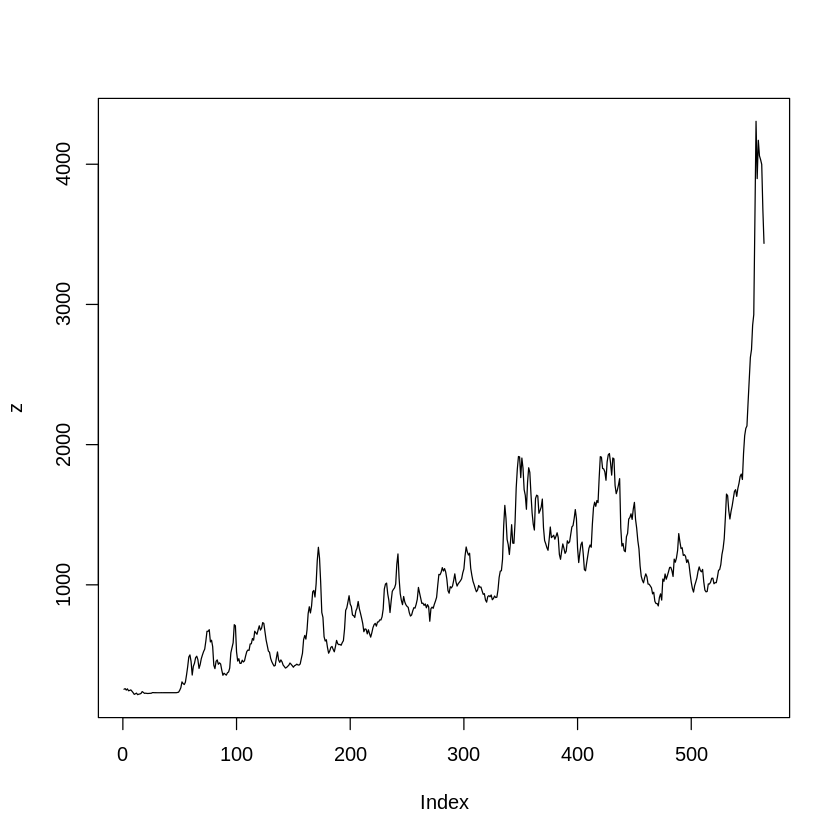

In [304]:
plot(z, type='l')

- 분산이 일정하지 않은 모습을 보여, 심지어 커지기 때문에 변수 변환이 필요하겠다.

```R
BoxCox.lambda(z, method='loglik')
```
```
0.25
```
- 분산안정화시켜주는 람다값은 0.25가 나왔다.

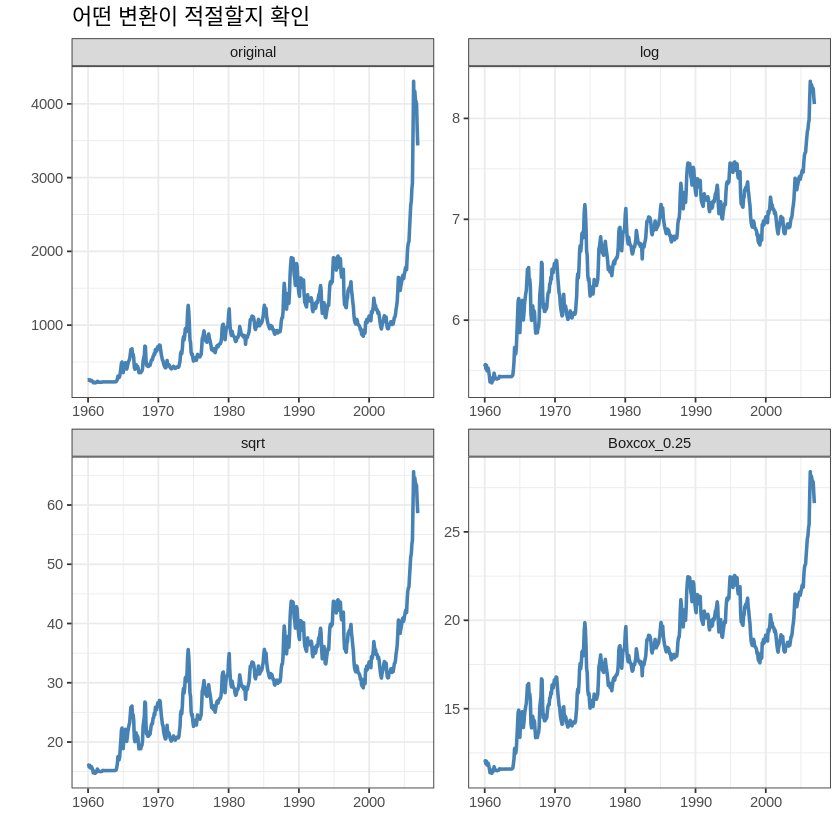

In [315]:
#collapse
tmp.dat <- data.table(
  t=seq.Date(as.Date("1960-01-01"), 
             by='month', 
             length.out=564),
  original=z,
  log = log(z),
  sqrt = sqrt(z),
  Boxcox_0.25 = BoxCox(z,lambda= BoxCox.lambda(z, method='loglik')) 
)
melt.tmp <- melt(tmp.dat, id=1)
ggplot(melt.tmp, aes(t,value)) + 
  geom_line(col='steelblue', lwd=1) +
  xlab("")+ylab("")+
  ggtitle("어떤 변환이 적절할지 확인")+
  theme_bw()+
  facet_wrap(.~variable, nrow = 2, scales = "free")

In [316]:
tmp.dat[, lnz:= log(z)]

- 시계열 그림을 그려보니 마지막이 독특하게 튀어나온 모습을 볼 수 있었고, 분산 안정화를 통해 정상화가 필요하겠다.
- 그림을 그려보니 trend는 모두 비슷하지만 log 변환이 가장 분산이 안정화되어 보인다.
- 그래서 log 변환을 적용했다.

##### (2) auto.arima 를 이용하여 예측 모형을 적합하여라. (형태 : ARIMA(p.d.q)(P,D,Q)s , 모수 추정값)

In [296]:
auto.arima(tmp.dat$lnz, trace=T, ic='aic')


 Fitting models using approximations to speed things up...

 ARIMA(2,1,2) with drift         : -1555.199
 ARIMA(0,1,0) with drift         : -1485.363
 ARIMA(1,1,0) with drift         : -1543.596
 ARIMA(0,1,1) with drift         : -1556.04
 ARIMA(0,1,0)                    : -1484.453
 ARIMA(1,1,1) with drift         : -1553.325
 ARIMA(0,1,2) with drift         : -1554.063
 ARIMA(1,1,2) with drift         : Inf
 ARIMA(0,1,1)                    : -1556.275
 ARIMA(1,1,1)                    : -1553.645
 ARIMA(0,1,2)                    : -1554.28
 ARIMA(1,1,0)                    : -1544.171
 ARIMA(1,1,2)                    : -1555.619

 Now re-fitting the best model(s) without approximations...

 ARIMA(0,1,1)                    : -1561.685

 Best model: ARIMA(0,1,1)                    



Series: tmp.dat$lnz 
ARIMA(0,1,1) 

Coefficients:
         ma1
      0.3756
s.e.  0.0385

sigma^2 estimated as 0.003634:  log likelihood=782.84
AIC=-1561.69   AICc=-1561.66   BIC=-1553.02

- auto.arima를 적용해보았다.
- [ARIMA(0.1.1)(0.0.0) 모수 추정값: 0.3756] 모형이 제일 적합하다는 결론이 나와 예측 모형을 적합해 보았다.

In [297]:
fit = arima(tmp.dat$lnz, order = c(0,1,1))
fit


Call:
arima(x = tmp.dat$lnz, order = c(0, 1, 1))

Coefficients:
         ma1
      0.3756
s.e.  0.0385

sigma^2 estimated as 0.003628:  log likelihood = 782.84,  aic = -1561.69

##### (3) (2)번 모형을 제외한 다른 후보 모형을 선택하여 적합하여라. . (형태 : ARIMA(p.d.q)(P,D,Q)s , 모수 추정값)

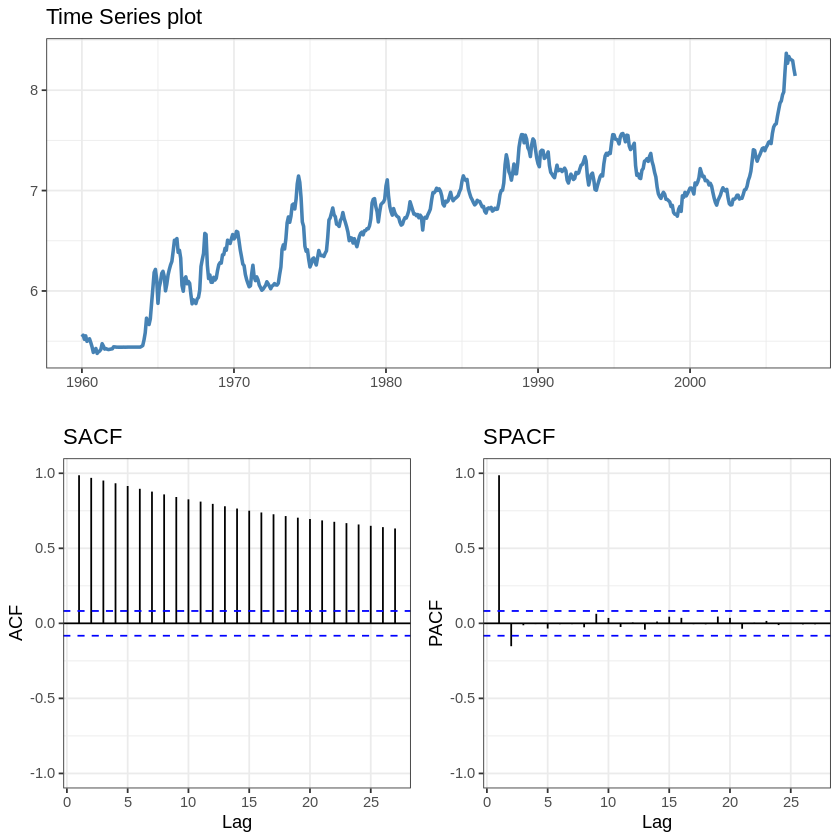

In [298]:
#collapse
p1 <- ggplot(tmp.dat, aes(t, lnz)) + geom_line(col='steelblue', lwd=1) + xlab("")+ylab("")+ ggtitle("Time Series plot")+  theme_bw()
p2 <- ggAcf(tmp.dat$lnz) +  theme_bw() + ylim(-1,1) + ggtitle("SACF")
p3 <- ggPacf(tmp.dat$lnz) + theme_bw() +ylim(-1,1) + ggtitle("SPACF")

grid.arrange(p1, p2, p3, nrow = 2, layout_matrix = rbind(c(1, 1),  c(2, 3)))

- log 변환 후 plot을 그려보니 추세와 계절성이 반복되어 나타나니 계절차분이 필요한가 판단된다.
- ACF가 지수적으로 천천히 감소하는 모습을 보인다.
- 확률보행과정을 통해 정상화 과정을 진행하였다.

In [317]:
set.seed(1)
e <- rnorm(100)

In [318]:
tmp.dat <- data.table(
  t=1:100,
  z=cumsum(e)
)
tmp.dat[, dz := c(0, diff(z))]

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



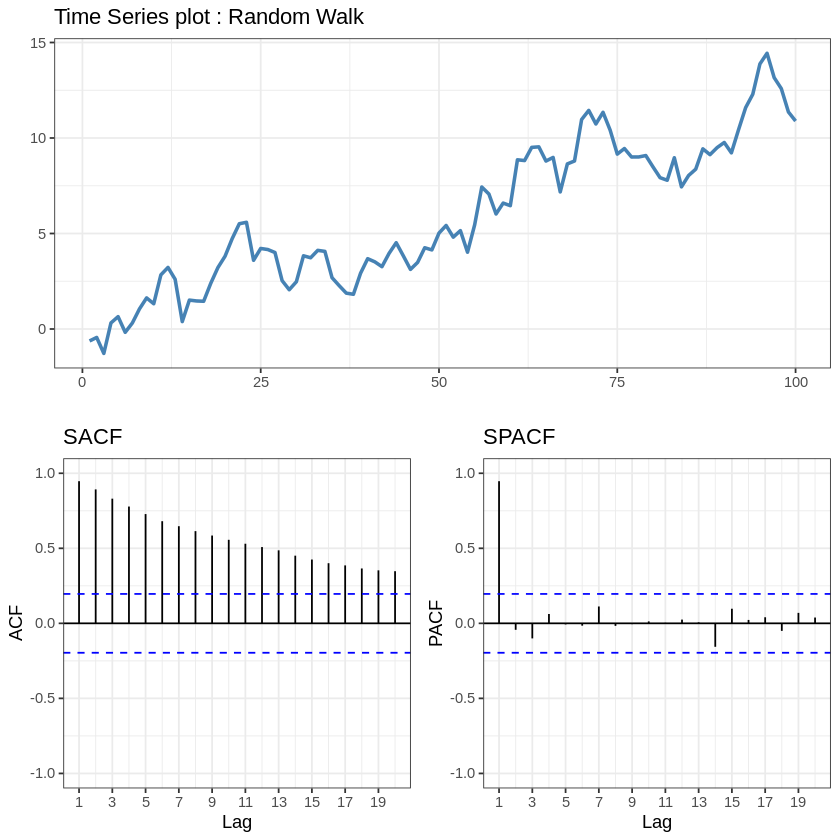

In [319]:
p1 <- ggplot(tmp.dat, aes(t, z)) + 
  geom_line(col='steelblue', lwd=1) +
  xlab("")+ylab("")+
  ggtitle("Time Series plot : Random Walk")+
  # scale_x_continuous(breaks = seq(0,30, by = 6))+
  # geom_hline(yintercept = 0, lty=2, col='grey')+
  theme_bw()
p2 <- ggAcf(tmp.dat$z) + 
  theme_bw() + ylim(-1,1) +
  scale_x_continuous(breaks = seq(1,20, by = 2))+
  ggtitle("SACF")

p3 <- ggPacf(tmp.dat$z) + 
  theme_bw() +ylim(-1,1) +
  scale_x_continuous(breaks = seq(1,20, by = 2))+
  ggtitle("SPACF")

grid.arrange(p1, p2, p3, nrow = 2,
             layout_matrix = rbind(c(1, 1),
                                   c(2, 3)))

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



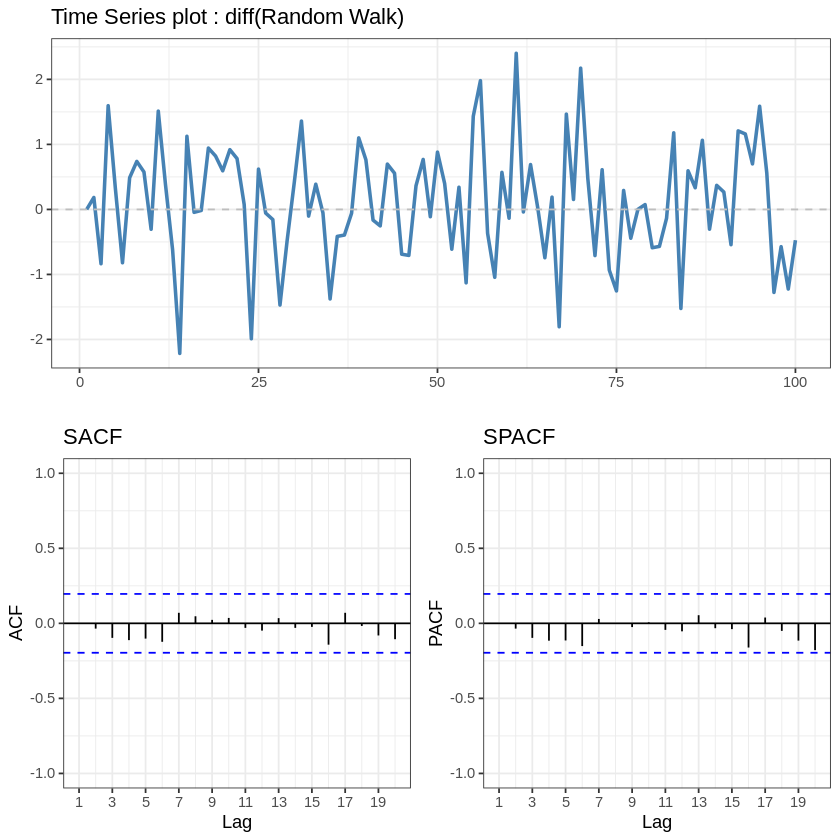

In [320]:
p1 <- ggplot(tmp.dat, aes(t, dz)) + 
  geom_line(col='steelblue', lwd=1) +
  xlab("")+ylab("")+
  ggtitle("Time Series plot : diff(Random Walk)")+
  # scale_x_continuous(breaks = seq(0,30, by = 6))+
  geom_hline(yintercept = 0, lty=2, col='grey')+
  theme_bw()

p2 <- ggAcf(tmp.dat$dz) + 
  theme_bw() + ylim(-1,1) +
  scale_x_continuous(breaks = seq(1,20, by = 2))+
  ggtitle("SACF")

p3 <- ggPacf(tmp.dat$dz) + 
  theme_bw() +ylim(-1,1) +
  scale_x_continuous(breaks = seq(1,20, by = 2))+
  ggtitle("SPACF")

grid.arrange(p1, p2, p3, nrow = 2,
             layout_matrix = rbind(c(1, 1),
                                   c(2, 3)))

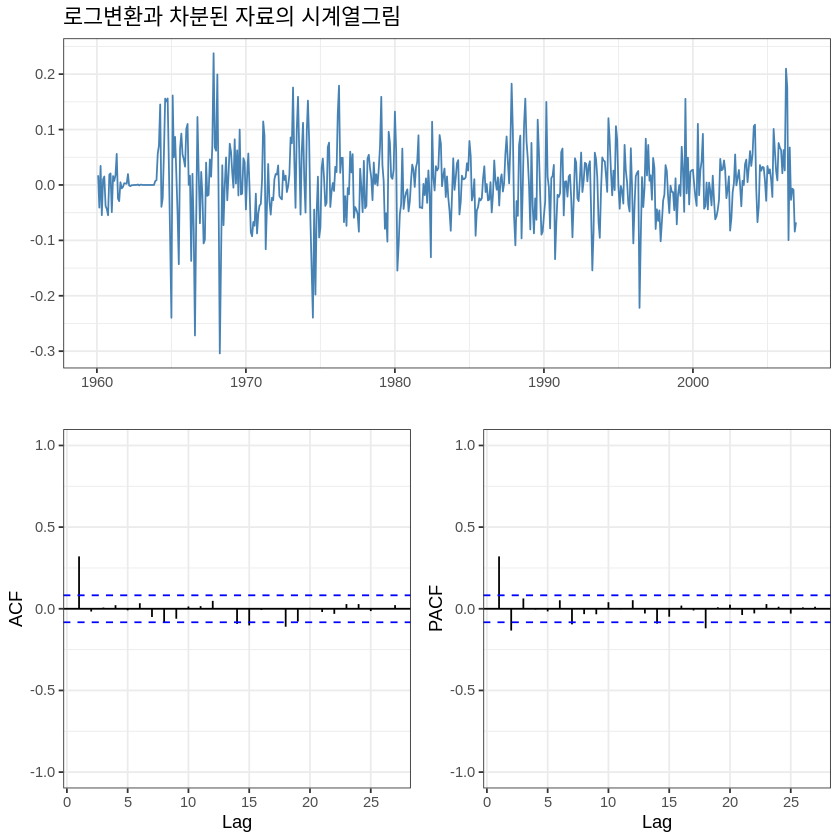

In [299]:
tmp.dat[, df1_lnz := c(0, diff(lnz))]
dt <- tmp.dat[-1,]

p3 <- ggplot(dt, aes(t, df1_lnz)) + geom_line(col='steelblue') +  xlab("")+ylab('')+ ggtitle('로그변환과 차분된 자료의 시계열그림')+ theme_bw()
p1 <- ggAcf(dt$df1_lnz) + theme_bw() + ylim(-1,1) + theme(plot.title = element_blank())
p2 <- ggPacf(dt$df1_lnz) +  theme_bw() +ylim(-1,1) + theme(plot.title = element_blank())
grid.arrange(p3, p1, p2, nrow = 2, layout_matrix = rbind(c(1,1), c(2,3)))

- 차분 후 시계열 그림을 보면 추세는 없고, 평균도 0 인것처럼보인다. 따라서 계절차분은 추가로 필요하지 않아보이며, 상수항 없는 단위근 검정 typr 옵션 nc 를 사용하였다.
- ACF, PACF 는 절단된 형태였다.

In [302]:
adfTest(dt$df1_lnz, lags = 0, type = "nc")
adfTest(dt$df1_lnz, lags = 1, type = "nc")
adfTest(dt$df1_lnz, lags = 2, type = "nc")

Warning message in adfTest(dt$df1_lnz, lags = 0, type = "nc"):
“p-value smaller than printed p-value”



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 0
  STATISTIC:
    Dickey-Fuller: -16.8919
  P VALUE:
    0.01 

Description:
 Sat Dec 11 21:26:36 2021 by user: 


Warning message in adfTest(dt$df1_lnz, lags = 1, type = "nc"):
“p-value smaller than printed p-value”



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 1
  STATISTIC:
    Dickey-Fuller: -15.6202
  P VALUE:
    0.01 

Description:
 Sat Dec 11 21:26:36 2021 by user: 


Warning message in adfTest(dt$df1_lnz, lags = 2, type = "nc"):
“p-value smaller than printed p-value”



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 2
  STATISTIC:
    Dickey-Fuller: -12.1536
  P VALUE:
    0.01 

Description:
 Sat Dec 11 21:26:36 2021 by user: 


- 단위근 검정을 해보아도 모두 기각하여 단위근이 없다는 결론이 나왔다.
- 따라서 추가적인 차분이 필요하지 않겠다.
- 상수항 없는 ARIMA(0,1,0)(0,0,0) 모형을 적합해보았다.

In [306]:
fit2 = arima(tmp.dat$lnz, order = c(0,1,0))
fit2


Call:
arima(x = tmp.dat$lnz, order = c(0, 1, 0))


sigma^2 estimated as 0.004137:  log likelihood = 745.97,  aic = -1489.94

##### (4) (2),(3)번 모형 중 어떤 모형일 더 적절한지 설명하여라.

In [307]:
summary(fit)
coeftest(fit)


Call:
arima(x = tmp.dat$lnz, order = c(0, 1, 1))

Coefficients:
         ma1
      0.3756
s.e.  0.0385

sigma^2 estimated as 0.003628:  log likelihood = 782.84,  aic = -1561.69

Training set error measures:
                      ME       RMSE        MAE        MPE      MAPE      MASE
Training set 0.003341946 0.06017865 0.04310712 0.04698529 0.6404858 0.9274756
                     ACF1
Training set -0.004096904


z test of coefficients:

    Estimate Std. Error z value  Pr(>|z|)    
ma1 0.375553   0.038466  9.7632 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


- (2)에서 적합한 모형이다.
- ARIMA(0.1.1)(0.0.0)

In [308]:
summary(fit2)
coeftest(fit2)


Call:
arima(x = tmp.dat$lnz, order = c(0, 1, 0))


sigma^2 estimated as 0.004137:  log likelihood = 745.97,  aic = -1489.94

Training set error measures:
                     ME       RMSE        MAE        MPE      MAPE      MASE
Training set 0.00461968 0.06426041 0.04640532 0.06375334 0.6886166 0.9984384
                  ACF1
Training set 0.3205564

ERROR: Error in dimnames(x) <- dn: length of 'dimnames' [2] not equal to array extent


- (3)에서 적합한 모형이다. 
- ARIMA(1,1,1)(0,0,0)

- AIC값은 (2)에서 적합한 모형이 더 작다.
- log likelihood 값은 (3)에서 적합한 모형이 더 크다.
- (3)모형을 선택하였다.

##### (5) (4)에서 선택한 모형을 이용하여 잔차검정을 시행하여라.

In [309]:
tmp.dat[, res := as.numeric(resid(fit1))]
p3 <- ggplot(tmp.dat, aes(t, res)) +  geom_line(col='steelblue') + xlab("")+ylab('')+ ggtitle('잔차의 시계열그림')+ theme_bw()
p1 <- ggAcf(tmp.dat$res2) +  theme_bw() + ylim(-1,1) +  theme(plot.title = element_blank())
p2 <- ggPacf(tmp.dat$res) +  theme_bw() +ylim(-1,1) + theme(plot.title = element_blank())
grid.arrange(p3, p1, p2, nrow = 2,  layout_matrix = rbind(c(1,1), c(2,3)))

ERROR: Error in `[.data.table`(tmp.dat, , `:=`(res, as.numeric(resid(fit1)))): Supplied 275 items to be assigned to 564 items of column 'res'. If you wish to 'recycle' the RHS please use rep() to make this intent clear to readers of your code.


- 잔차 plot이 잘 흩어져 있는 모습이다.
- ACF와 PACF가 모두 유의하지 않은 모습이었다. 백색소음!

In [194]:
dwtest(tmp.dat$res2~1)


	Durbin-Watson test

data:  tmp.dat$res2 ~ 1
DW = 2.0048, p-value = 0.5229
alternative hypothesis: true autocorrelation is greater than 0


- 더빈왓슨 검정 결과 p값은 유의하지 않아 자기상관관계가 없다고 할 수 있다.

In [195]:
LjungBox(fit2, lags=seq(6,24,6))# 잔차의 포트맨토검정  

,lags,statistic,df,p-value
,6,4.36822,4,0.35846040
,12,11.78529,10,0.29968310
,18,25.47615,16,0.06185941
,24,29.64746,22,0.12728780


- 잔차의 포트맨토 검정 결과도 모두 유의하지 않은 모습이었다.

In [196]:
shapiro.test(tmp.dat$res2) 


	Shapiro-Wilk normality test

data:  tmp.dat$res2
W = 0.96373, p-value = 1.409e-10


- 하지만 정규성 가정을 만족하지 않은 모습이다.

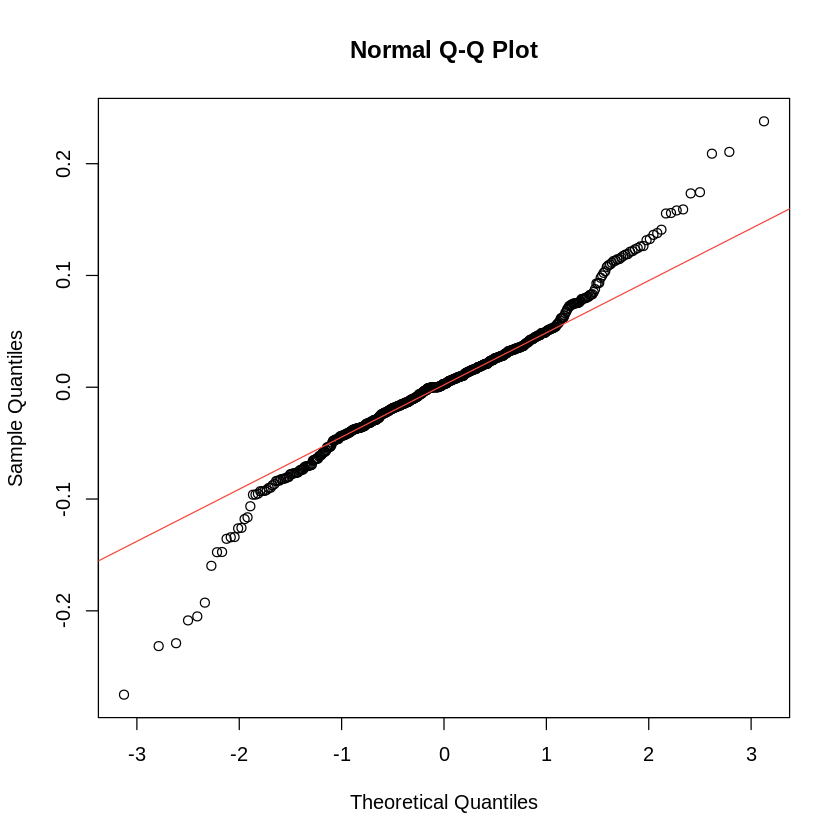

In [197]:
qqnorm(tmp.dat$res2)
qqline(tmp.dat$res2, col = 2)

##### (6) 2007년과 2008년 데이터를 예측하여라

$pred
Time Series:
Start = 565 
End = 588 
Frequency = 1 
 [1] 8.131459 8.136316 8.140932 8.145551 8.150171 8.154790 8.159410 8.164030
 [9] 8.168649 8.173269 8.177889 8.182508 8.187128 8.191747 8.196367 8.200987
[17] 8.205606 8.210226 8.214845 8.219465 8.224085 8.228704 8.233324 8.237943

$se
Time Series:
Start = 565 
End = 588 
Frequency = 1 
 [1] 0.06013671 0.10204984 0.13097485 0.15458186 0.17503337 0.19333341
 [7] 0.21004508 0.22552175 0.24000248 0.25365787 0.26661478 0.27897055
[13] 0.29080182 0.30217019 0.31312609 0.32371141 0.33396138 0.34390599
[19] 0.35357101 0.36297877 0.37214878 0.38109820 0.38984224 0.39839440

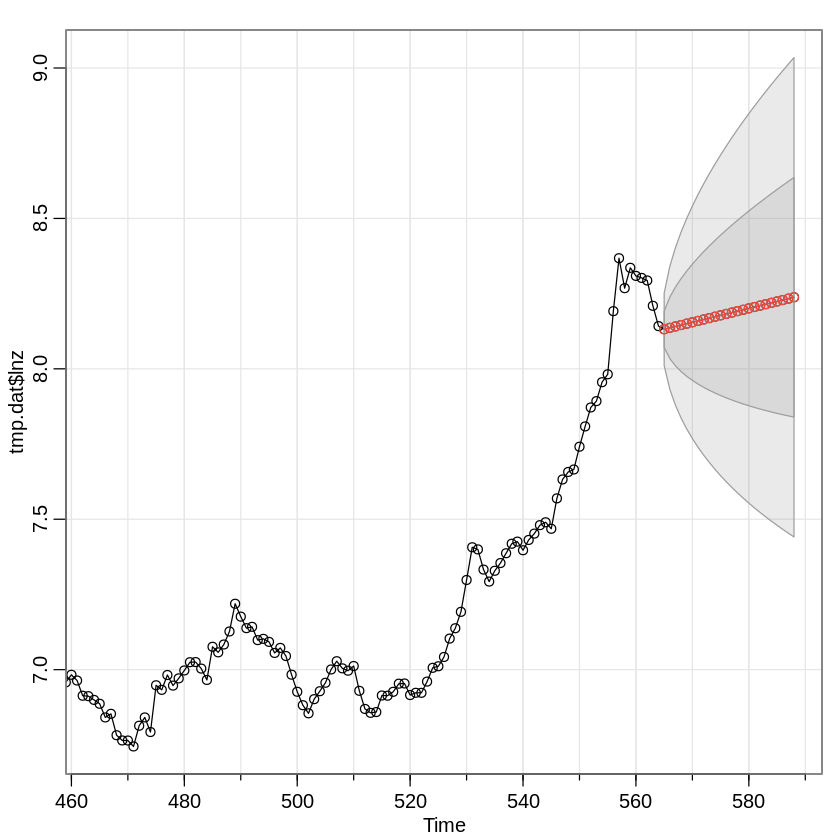

In [291]:
sarima.for(tmp.dat$lnz, 24, 1,1,1) 

- 2007년과 2008년 데이터를 예측해보았다.
- 평균 근처에서 잘 예측되는 모습이다.

#### 2. 사용할 데이터 : hsales

##### (1) 변수변환이 필요한지를 설명하고 , 필요하다면 적절한 변수 변환을 하여라 

In [235]:
z<-as.numeric(hsales)
length(z)

[1] 275

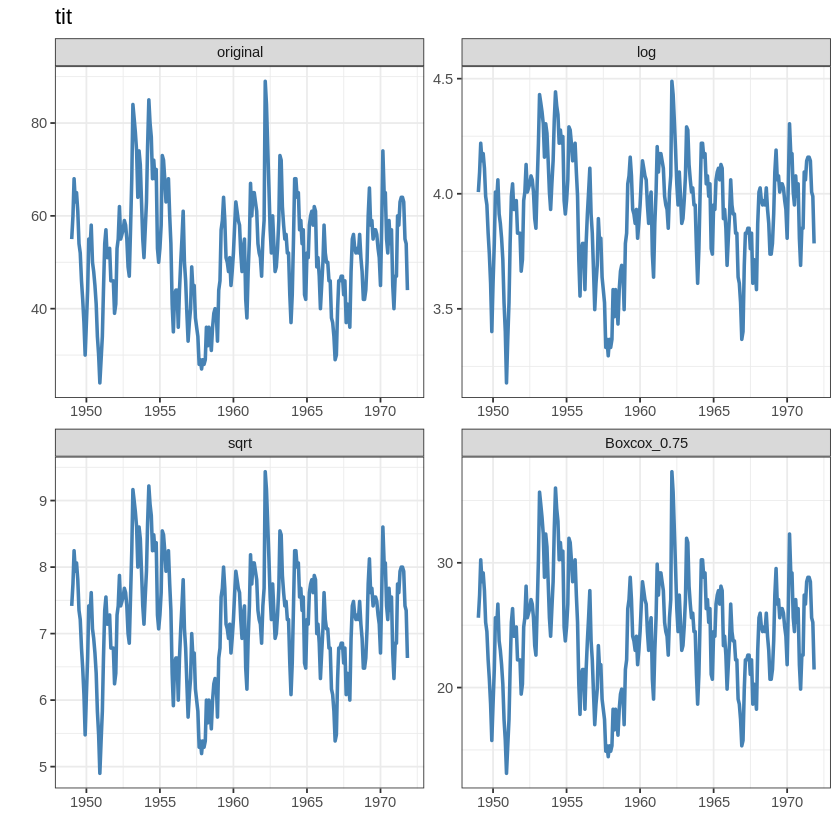

In [236]:
tmp.dat <- data.table(t=seq.Date(as.Date("1949-01-01"),by='month',length.out=275),
  original=z, log = log(z), sqrt = sqrt(z),
  Boxcox_0.75 = BoxCox(z,lambda= BoxCox.lambda(z, method='loglik')) 
)
melt.tmp <- melt(tmp.dat, id=1)
ggplot(melt.tmp, aes(t,value)) + 
  geom_line(col='steelblue', lwd=1) +
  xlab("")+ylab("")+
  ggtitle("tit")+
  theme_bw()+
  facet_wrap(.~variable, nrow = 2, scales = "free")

- 변수 변환은 필요 없어보인다.
- 추세가 존재하지도 않고 이분산성도 보이지 않기 때문이다.

##### (2) 데이터가 정상시계열인가 ? 아니면 적절한 차분을 통해 정상시계열로 변환하여라 .

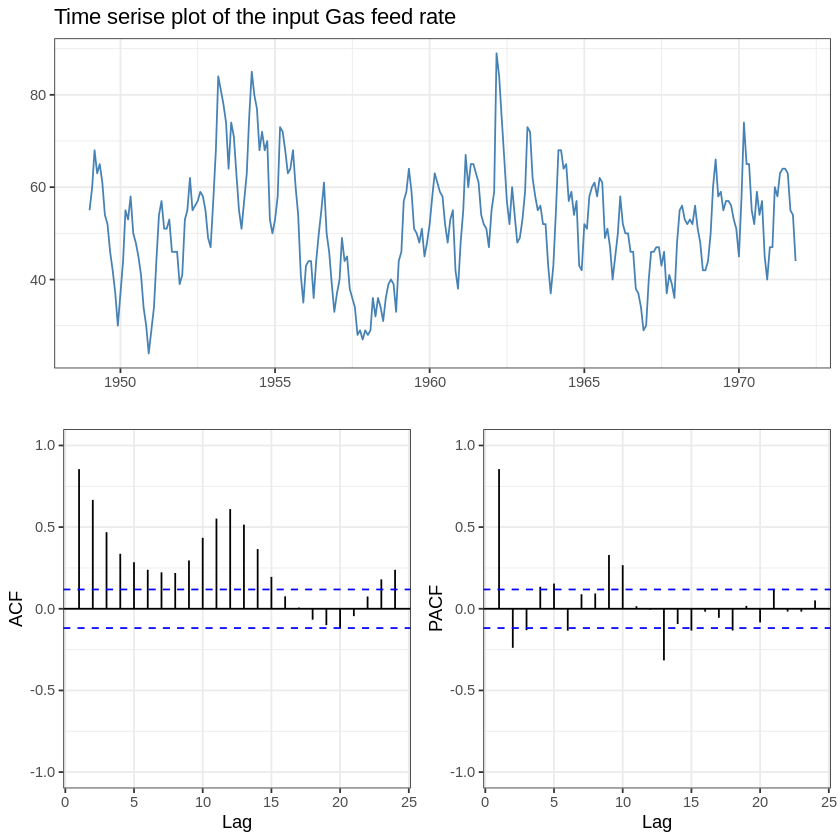

In [237]:
p3 <- ggplot(tmp.dat, aes(t, original)) +  geom_line(col='steelblue') +
  xlab("")+ylab('')+ ggtitle('Time serise plot of the input Gas feed rate')+
  theme_bw()
p1 <- ggAcf(tmp.dat$original) +  theme_bw() + ylim(-1,1) +
  theme(plot.title = element_blank())
p2 <- ggPacf(tmp.dat$original) + theme_bw() +ylim(-1,1) +
  theme(plot.title = element_blank())
grid.arrange(p3, p1, p2, nrow = 2,
             layout_matrix = rbind(c(1,1), c(2,3)))

- 추세가 없어보임, 평균이 60인 것 같다.
- ACF가 빠르게 감소하고 있는 것처럼 보이면서 산처럼 솟은 곳이 보여 계절차분을 해도 되겠다.
- 혹은 ACF가 천천히 감소한다고 보고 차분을 먼저 해볼 수도 있겠다.
- PACF 1 이후 유의한 부분이 보인다. 아마 ACF에서 판단한 것처럼 계절차분이 필요하기 때문이지 않을까? 
- 혹은 ACF가 빠르게 감소한다고 보고, PACF를 1시차에서 절단된다고 봐서 AR(1) 모형을 적합해보는 방법도 고려해봤다.

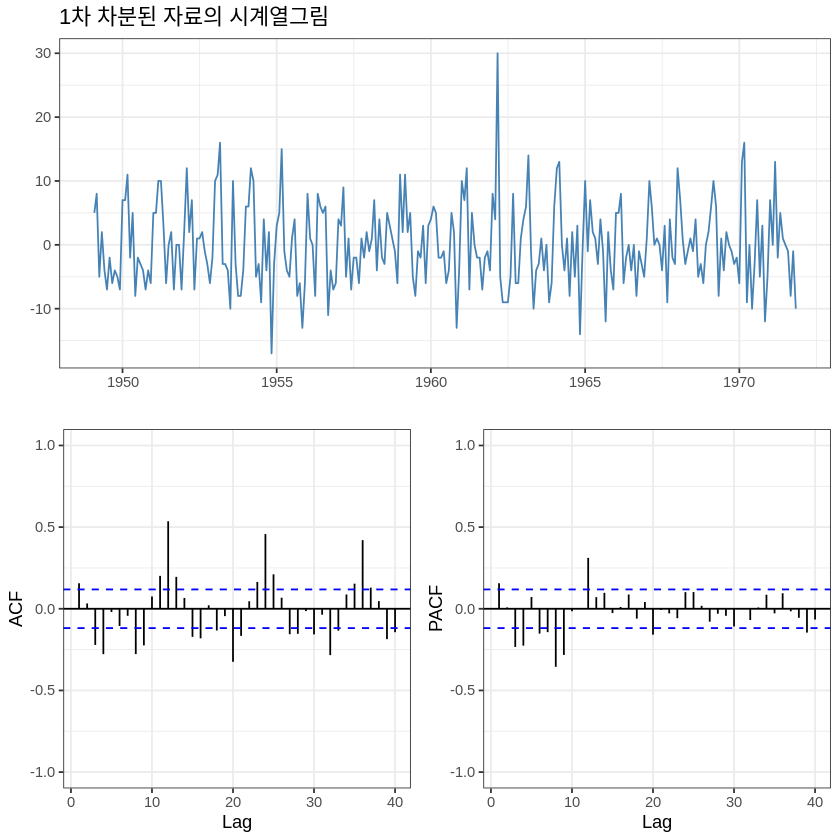

In [263]:
tmp.dat[, df1_z := c(0, diff(original))]
dt <- tmp.dat[-1,]
p3 <- ggplot(dt, aes(t, df1_z)) +  geom_line(col='steelblue') + xlab("")+ylab('')+ ggtitle('1차 차분된 자료의 시계열그림')+ theme_bw()
p1 <- ggAcf(dt$df1_z, lag.max = 40) +   theme_bw() + ylim(-1,1) + theme(plot.title = element_blank())
p2 <- ggPacf(dt$df1_z, lag.max = 40) +  theme_bw() +ylim(-1,1) + theme(plot.title = element_blank())
grid.arrange(p3, p1, p2, nrow = 2,   layout_matrix = rbind(c(1,1),    c(2,3)))

- 1차 차분 후 plot을 보니 위에서 예측한대로 계절주기가 보이는 것 같다.
- 즉, 우똑 솟은 유의한 값 양쪽으로도 유의한 모습을 보이고 있었다.
- 시계열 plot에서 일단 계절성이 뚜렷하고, ACF에서 주기 주변으로 유의한 값이 있는 모습, 그리고 PACF도 계절 주기에 해당되는 시차에서 서서히 감소하고 있어 계절차분이 추가로 필요함을 알 수 있었다.

In [239]:
adfTest(dt$df1_z, lags = 0, type = "nc")
adfTest(dt$df1_z, lags = 1, type = "nc")
adfTest(dt$df1_z, lags = 2, type = "nc")

Warning message in adfTest(dt$df1_z, lags = 0, type = "nc"):
“p-value smaller than printed p-value”



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 0
  STATISTIC:
    Dickey-Fuller: -14.0192
  P VALUE:
    0.01 

Description:
 Sat Dec 11 20:31:42 2021 by user: 


Warning message in adfTest(dt$df1_z, lags = 1, type = "nc"):
“p-value smaller than printed p-value”



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 1
  STATISTIC:
    Dickey-Fuller: -10.5881
  P VALUE:
    0.01 

Description:
 Sat Dec 11 20:31:42 2021 by user: 


Warning message in adfTest(dt$df1_z, lags = 2, type = "nc"):
“p-value smaller than printed p-value”



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 2
  STATISTIC:
    Dickey-Fuller: -11.1907
  P VALUE:
    0.01 

Description:
 Sat Dec 11 20:31:42 2021 by user: 


- 단위근 검정을 해보니 p 값이 모두 작아 모두 기각하였으며, 단위근이 없다는 결론이 나왔다.

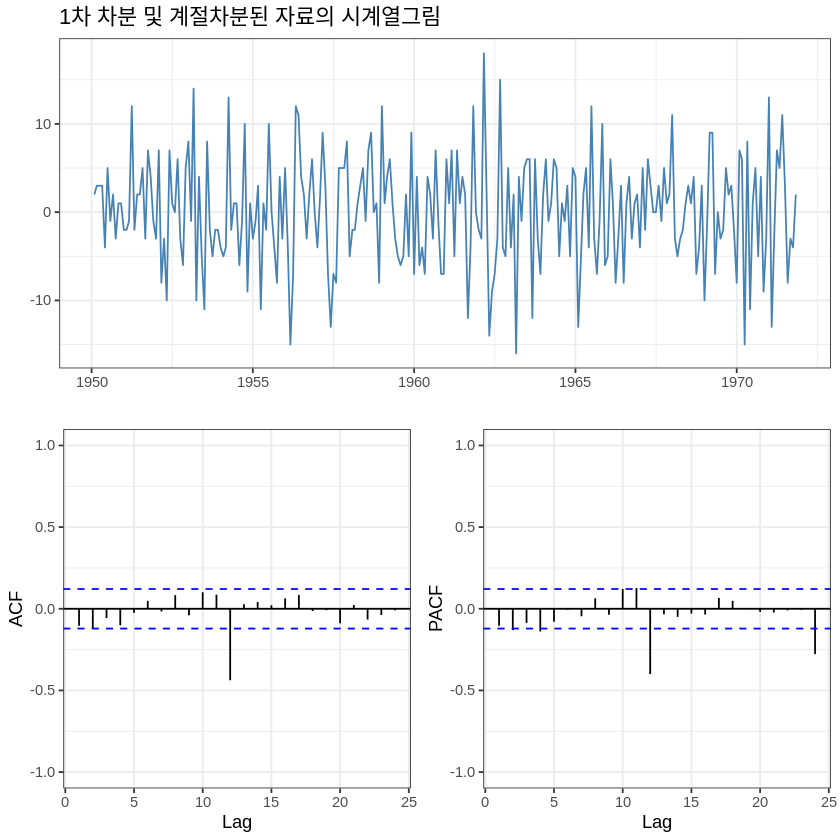

In [262]:
dt[, df12_df1_z := c(rep(0,12), diff(df1_z,12))]
sdt <- dt[-(1:12)]
p3 <- ggplot(sdt, aes(t, df12_df1_z)) + geom_line(col='steelblue') +xlab("")+ylab('')+ ggtitle('1차 차분 및 계절차분된 자료의 시계열그림')+theme_bw()
p1 <- ggAcf(sdt$df12_df1_z) + theme_bw() + ylim(-1,1) + theme(plot.title = element_blank())
p2 <- ggPacf(sdt$df12_df1_z) +  theme_bw() +ylim(-1,1) +theme(plot.title = element_blank())
grid.arrange(p3, p1, p2, nrow = 2,   layout_matrix = rbind(c(1,1), c(2,3)))

- 1차 차분 및 계절차분된 시계열 plot은 평균이 0ㅇ인 것처럼 보이며,
- ACF는 12에서만 유의하며,
- PACF는 12,24에서 주기적으로 유의한 값을 띄었다.
- 정상성을 띄고 있는 것으로 보면서,
- 동시에 상수항이 없는 ARIMA(0,0,0)(0,0,2)_12 모형 잠정모형으로 적절할 것 같다는 생각을 했다.

In [241]:
adfTest(sdt$df12_df1_z, lags = 0, type = "nc")
adfTest(sdt$df12_df1_z, lags = 1, type = "nc")
adfTest(sdt$df12_df1_z, lags = 2, type = "nc")

Warning message in adfTest(sdt$df12_df1_z, lags = 0, type = "nc"):
“p-value smaller than printed p-value”



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 0
  STATISTIC:
    Dickey-Fuller: -17.8939
  P VALUE:
    0.01 

Description:
 Sat Dec 11 20:31:44 2021 by user: 


Warning message in adfTest(sdt$df12_df1_z, lags = 1, type = "nc"):
“p-value smaller than printed p-value”



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 1
  STATISTIC:
    Dickey-Fuller: -13.6238
  P VALUE:
    0.01 

Description:
 Sat Dec 11 20:31:44 2021 by user: 


Warning message in adfTest(sdt$df12_df1_z, lags = 2, type = "nc"):
“p-value smaller than printed p-value”



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 2
  STATISTIC:
    Dickey-Fuller: -11.3109
  P VALUE:
    0.01 

Description:
 Sat Dec 11 20:31:44 2021 by user: 


- 단위 검정 결과 모두 기각하여 단위근이 없다는 결과가 나왔다.
- 분산이 안정화되어 있고, 추세 및 계절성도 없어 정상시계열로 변환된 것 같다.

##### (3) 모형을 식별하여라 . (2 개 이상의 모형 고려 )( 형태 : ARIMA( p.d.q )(P,D,Q)s )

- (2)에서 예측한대로 상수항이 없는 ARIMA(0,0,0)(0,0,2)_12 모형이 적절해 보인다. 이때 이 잠정 모형은 1차 차분 및 계절차분에서 나온 값이기 때문에 **ARIMA(0,1,0)(0,1,2)_12** 모형을 잠정모형으로 선택하였다.
- 혹은 계절 차분 전 ACF 및 PACF 를 보아 상수항 없는 ARIMA(0,0,1)(1,0,0)_12 모형도 적합해볼 수 있겠다. 이때도 1차 차분한 데이터에서 추정한 것이기 때문에 모형 적합에서는 **ARIMA(0,1,1)(1,0,0)_12** 모형을 선택하였다.

##### (4) (3) 에서 고려한 모형을 적합하여라 . ( 형태 : ARIMA( p.d.q )(P,D,Q)s, 모수추정값 )

In [273]:
### ARIMA(0,1,0)(0,1,2)_12
fit1 = arima(tmp.dat$original, order = c(0,1,0), seasonal = list(order = c(0,1,2), period = 12))
fit1


Call:
arima(x = tmp.dat$original, order = c(0, 1, 0), seasonal = list(order = c(0, 
    1, 2), period = 12))

Coefficients:
         sma1     sma2
      -0.9002  -0.0998
s.e.   0.0809   0.0614

sigma^2 estimated as 19.86:  log likelihood = -781.01,  aic = 1568.02

- AIC 값은 1568.02이 나왔다.
- log likelihood는 -781.01 이 나왔고,
- coeff는 모두 유의하지 않게 나왔으며,
- 모수 추정값은 sma1=-0.9002, sma2=-0.0999가 나왔다.

In [274]:
## ARIMA(0,1,1)(1,0,0)_12
fit2 = arima(tmp.dat$original, order = c(0,1,1), seasonal = list(order = c(1,0,0), period = 12))
fit2


Call:
arima(x = tmp.dat$original, order = c(0, 1, 1), seasonal = list(order = c(1, 
    0, 0), period = 12))

Coefficients:
          ma1    sar1
      -0.0267  0.5571
s.e.   0.0686  0.0522

sigma^2 estimated as 28.36:  log likelihood = -849.29,  aic = 1704.58

- AIC 값은 1704.58가 나왔다.
- log likelihood 는 -849.29 이 나왔다.
- coeff는 모두 유의하지 않게 나왔으며,
- 모수 추정값은 ma1=-0.0267, sar1=0.5571 가 나왔다.

##### (5) (4) 에서 적합된 결과를 이용하여 더 좋은 모형을 선택하여라 .

- ARIMA(0,1,0)(0,1,2)_12
- 모형의 AIC 값이 더 작게 나왔고, log liklihooe 도 더 크게 나왔다.
- 따라서 첫번째 fit1 모형을 선택했다.

##### (6) (5) 에서 선택한 모형을 이용하여 잔차검정을 시행하여라 .

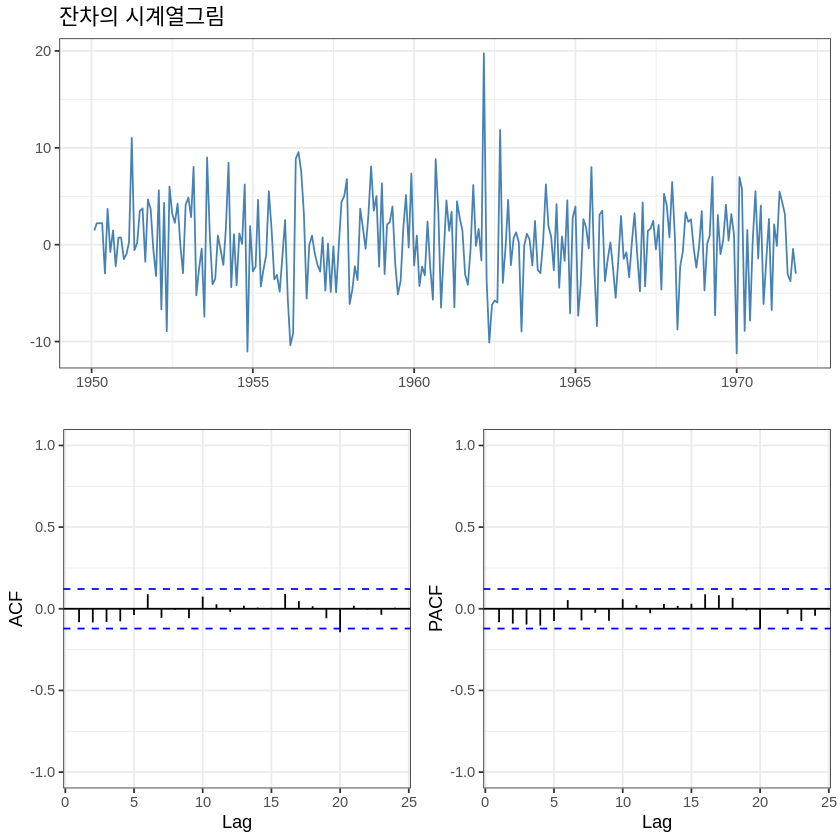

In [276]:
tmp.dat[, res1 := as.numeric(resid(fit1))]
p3 <- ggplot(sdt, aes(t, res1)) + geom_line(col='steelblue') +
  xlab("")+ylab('')+ ggtitle('잔차의 시계열그림')+ theme_bw()
p1 <- ggAcf(sdt$res1) + theme_bw() + ylim(-1,1) + theme(plot.title = element_blank())
p2 <- ggPacf(sdt$res1) + theme_bw() +ylim(-1,1) + theme(plot.title = element_blank())
grid.arrange(p3, p1, p2, nrow = 2,  layout_matrix = rbind(c(1,1), c(2,3)))

- 잔차 plot을 보니 평균이 0인 것 같지만 분산이 정말 안정한지 애매하다.
- ACF, PACF 에서 유의한 값은 보이지 않았다.

In [277]:
LjungBox(fit1, lags=seq(6,24,6))

,lags,statistic,df,p-value
,6,10.04279,4,0.0397131
,12,13.81602,10,0.1815499
,18,16.96501,16,0.3878650
,24,24.77098,22,0.3081517


- 잔차의 포트맨토검정 결과 모두 유의하지 않은 모습이었다.

In [278]:
shapiro.test(sdt$res) 


	Shapiro-Wilk normality test

data:  sdt$res
W = 0.99, p-value = 0.0687


- 정규성 검정 결과 p값이 0.0687으로 정규성 가정을 만족하는 모습이다.

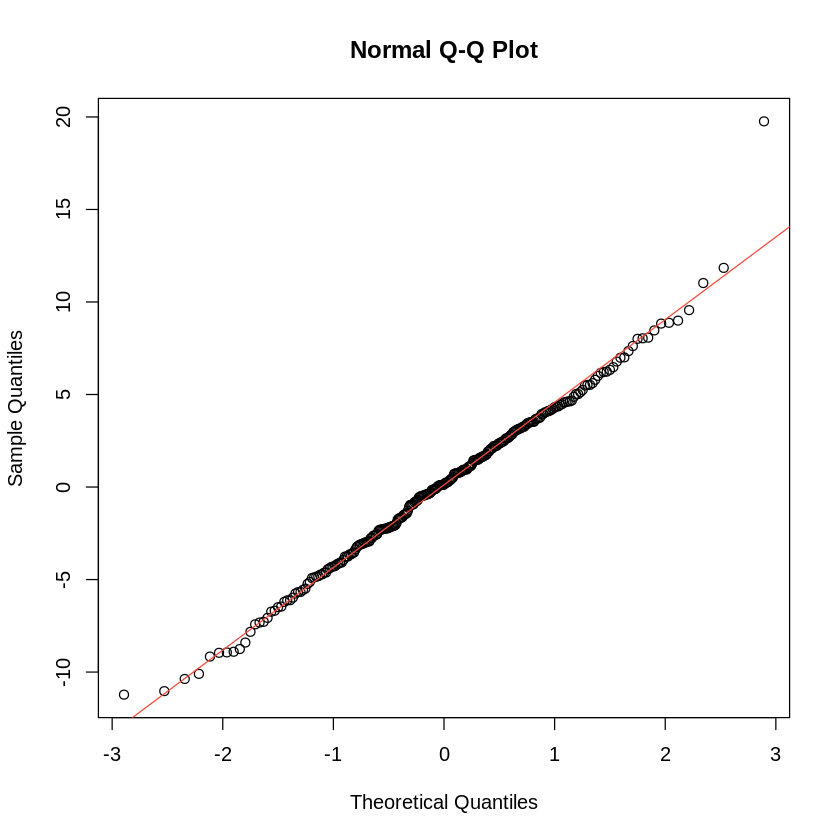

In [279]:
qqnorm(sdt$res)
qqline(sdt$res, col = 2)

- qqplot을 봐도 직선에 잘 적합해보여 잔차들의 분포가 정규성 가정을 만족하는 것을 알 수 있었다.

##### (7) 다음 2년간의 값을 예측하여라 .

$pred
Time Series:
Start = 276 
End = 287 
Frequency = 1 
 [1] 43.95985 43.91971 43.87956 43.83942 43.79927 43.75912 43.71898 43.67883
 [9] 43.63869 43.59854 43.55839 43.51825

$se
Time Series:
Start = 276 
End = 287 
Frequency = 1 
 [1]  6.406702  9.060445 11.096734 12.813404 14.325822 15.693151 16.950541
 [8] 18.120890 19.220107 20.259771 21.248627 22.193468

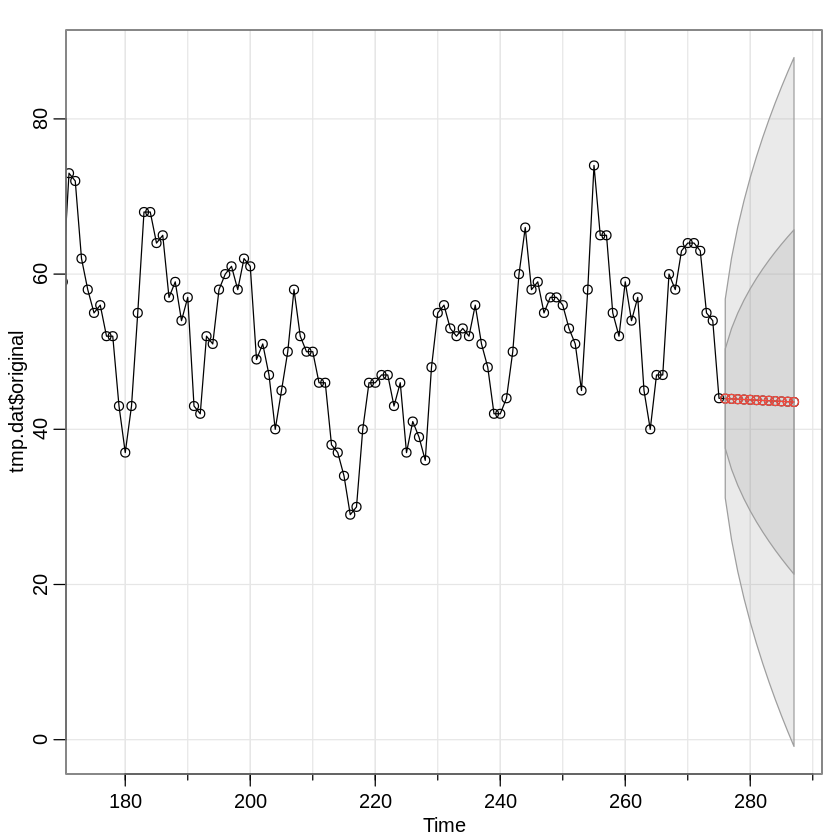

In [281]:
sarima.for(tmp.dat$original, 12, 0,1,0)

- 예측값은 n+2 시점만 영향을 받고 다음부터 표본 평균에 가깝게 나온다.

#### 3 사용할 데이터 : ukcars
##### (1) 변수변환이 필요한지를 설명하고, 필요하다면 적절한 변수 변환을 하여라. 
(변수변환을 시행하였으면, 아래의 분석을 변환된 값으로 수행함)
(2) 마지막 2년동안의 데이터는 test데이터, 나머지는 train 데이터로 분할하여라.
(3) 이동평균을 이용하여 마지막 2년을 예측하여라
(4) 지수평활법을 이용하여 마지막 2년을 예측하여라
(5) 계절형 ARIMA 모형을 적합하여 마지막 2년을 예측하여라.
(6) 예측값과 실제값을 이용하여 (3)-(5) 모형 중 가장 좋은 모형을 선택하여라